I originally had planned to webscrap a website called FotMob, which is one of the major places to get Soccer statistics online. I had found a code on Github which was supposed to webscrape the data for me using selenium, however, the Github code that I had found was from 2021, and the code used a Driver path that had expired, or had changed since 2021. Then I tried to update the code. After trying to update the code to redo the path so that it's updated to the current year, I ran into a new issue that Google Colab couldn't download the proper selenium driver, and the update was needed to run the code. Following that, I decided that I would try to web scrape the data myself from the Fot Mob website. However, once I tried writing the code for that, I found out that the HTML link for the data I was trying to get wasn't publicly accessible and I wouldn't be able to webscrape all the data needed for the type of data analysis I was trying ot perform. Fotmob does have publicly available API's, however, you can only webscrape a very small amount of data from their public API's and it wouldn't be enough for a deep dive into the stats that I was looking for. After doing a little more research I found that the only way to do it would be to use the selenium package however since the version I needed wasn't avaliable on collab I would need to use a sort of back route way to trick the system into thinking that I havea access and I really had no idea how to do that so I decided to look into different websites who may have the stats In a CSV file I was looking for, without webscraping the data myself. I came across one with the exact type Of data that I was looking for, however if I wanted to use the data file for the current year I would need to pay 20$, so I decided to use the 2018-2019 data set instead, which was a sample file that I have free access to. For me, the year doesn't matter because if I wanted to see how my data formula works, I can simply put a new data file in. I plan to create a formula to see which stats have the most impact on the chance of winning, and then create a formula to see which teams should have won the league based on my formula, versus the one that ended up winning the league.

So I guess my question is, which team based on the Algorithim I use will end up winning the Premier League in 2018/2019?

Here I am going to start with the data from the CSV file that I downloaded online. I got the CSV file from this website https://footystats.org/download-stats-csv#  I will start my anlaysis with first downloading all the proper programs and then cleaning up my data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler





In [3]:
import pandas as pd
df = pd.read_csv("/content/england-premier-league-matches-2018-to-2019-stats.csv")
print("Columns:", df.columns.tolist())



Columns: ['timestamp', 'date_GMT', 'status', 'attendance', 'home_team_name', 'away_team_name', 'referee', 'Game Week', 'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 'total_goals_at_half_time', 'home_team_goal_count_half_time', 'away_team_goal_count_half_time', 'home_team_goal_timings', 'away_team_goal_timings', 'home_team_corner_count', 'away_team_corner_count', 'home_team_yellow_cards', 'home_team_red_cards', 'away_team_yellow_cards', 'away_team_red_cards', 'home_team_first_half_cards', 'home_team_second_half_cards', 'away_team_first_half_cards', 'away_team_second_half_cards', 'home_team_shots', 'away_team_shots', 'home_team_shots_on_target', 'away_team_shots_on_target', 'home_team_shots_off_target', 'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls', 'home_team_possession', 'away_team_possession', 'Home Team Pre-Match xG', 'Away Team Pre-Match xG', 'team_a_xg', 'team_b_xg', '

So my first attempt at building a formula was using a Pearson Correlation model to find a correlation between the different stats and winning, which is a linear model type. However, after doing that, I realized that the 'Goals_for' column had over 63% weight on the outcome of the match, and that after I removed any goal-related columns, there wasn't enough data to make any of the other models statistically significant. So all the teams ended up having the same number of wins since every game became a 50/50 flip because the stats left didn't have enough of an impact on the game to decide the outcome. So after that, I decided that I needed to find a new model to try and build my formula.

In [4]:
df['home_win'] = (df['home_team_goal_count'] > df['away_team_goal_count']).astype(int)
df['away_win'] = (df['away_team_goal_count'] > df['home_team_goal_count']).astype(int)

home_df = df.copy()
home_df['team'] = home_df['home_team_name']
home_df['opponent'] = home_df['away_team_name']
home_df['goals_for'] = home_df['home_team_goal_count']
home_df['goals_against'] = home_df['away_team_goal_count']
home_df['win'] = home_df['home_win']
home_df['is_home'] = 1

away_df = df.copy()
away_df['team'] = away_df['away_team_name']
away_df['opponent'] = away_df['home_team_name']
away_df['goals_for'] = away_df['away_team_goal_count']
away_df['goals_against'] = away_df['home_team_goal_count']
away_df['win'] = away_df['away_win']
away_df['is_home'] = 0

combined = pd.concat([home_df, away_df], ignore_index=True)

betting_cols = [col for col in combined.columns if 'odds' in col or 'bookmaker' in col or 'bet' in col]
drop_cols = ['home_team_name', 'away_team_name',
             'home_team_goal_count', 'away_team_goal_count',
             'home_win', 'away_win','total_goal_count','total_goals_at_half_time',] + betting_cols
combined = combined.drop(columns=drop_cols)

numeric = combined.select_dtypes(include='number')
correlations = numeric.corr()['win'].drop('win').sort_values(ascending=False)

top_stats = correlations.head(6)
weights = top_stats / top_stats.sum()

combined['weighted_score'] = sum(combined[stat] * weight for stat, weight in weights.items())

combined['match_id'] = combined.groupby(['date_GMT', 'stadium_name']).ngroup()

match_scores = combined[['match_id', 'team', 'weighted_score']]
winners = match_scores.sort_values('weighted_score', ascending=False).groupby('match_id').first().reset_index()

deserved_table = winners['team'].value_counts().reset_index()
deserved_table.columns = ['team', 'deserved_wins']
for stat in top_stats.index:
    deserved_table[f'weight_{stat}'] = weights[stat]

print(deserved_table)

                       team  deserved_wins  weight_goals_for  weight_is_home  \
0           Manchester City             32          0.694692        0.143165   
1                 Liverpool             32          0.694692        0.143165   
2                   Chelsea             27          0.694692        0.143165   
3         Tottenham Hotspur             25          0.694692        0.143165   
4         Manchester United             25          0.694692        0.143165   
5                   Arsenal             24          0.694692        0.143165   
6   Wolverhampton Wanderers             20          0.694692        0.143165   
7                   Everton             19          0.694692        0.143165   
8           West Ham United             19          0.694692        0.143165   
9            Crystal Palace             19          0.694692        0.143165   
10          AFC Bournemouth             18          0.694692        0.143165   
11           Leicester City             

So after doing a little more research and working with Chat GPT to see which sort of method is a good way to create a formula for my data, I came across the random Forest Algorithm. This involved using a higher number of "trees" to create weighted predictions based on the data they got. Which sounded like a great way to predict the winners, since a game has binary outputs, win or loss (I decided not to include draws because that became too complicated and would statistically be unlikely for each team to have played exactly equal)it was a great way to predict the number of wins per team.

Here are some links to the sources that I used to help me learn more about Random Forest:
https://www.youtube.com/watch?v=_QuGM_FW9eo
https://www.youtube.com/watch?v=v6VJ2RO66Ag
https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/


In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

df['home_win'] = (df['home_team_goal_count'] > df['away_team_goal_count']).astype(int)
df['away_win'] = (df['away_team_goal_count'] > df['home_team_goal_count']).astype(int)

home_df = df.copy()
home_df['team'] = home_df['home_team_name']
home_df['opponent'] = home_df['away_team_name']
home_df['goals_for'] = home_df['home_team_goal_count']
home_df['goals_against'] = home_df['away_team_goal_count']
home_df['win'] = home_df['home_win']
home_df['is_home'] = 1

away_df = df.copy()
away_df['team'] = away_df['away_team_name']
away_df['opponent'] = away_df['home_team_name']
away_df['goals_for'] = away_df['away_team_goal_count']
away_df['goals_against'] = away_df['home_team_goal_count']
away_df['win'] = away_df['away_win']
away_df['is_home'] = 0

combined = pd.concat([home_df, away_df], ignore_index=True)

betting_cols = [col for col in combined.columns if 'odds' in col or 'bookmaker' in col or 'bet' in col]
drop_cols = ['home_team_name', 'away_team_name',
             'home_team_goal_count', 'away_team_goal_count',
             'home_win', 'away_win'] + betting_cols
combined = combined.drop(columns=drop_cols)

if 'team_a_xg' in combined.columns and 'team_b_xg' in combined.columns:
    combined['xg_diff'] = combined['team_a_xg'] - combined['team_b_xg']
else:
    combined['xg_diff'] = 0

exclude_keywords = ['goal', 'score', 'goals_for', 'goals_against', 'win']
numeric = combined.select_dtypes(include='number')
non_goal_cols = [col for col in numeric.columns if not any(key in col for key in exclude_keywords)]
if 'xg_diff' not in non_goal_cols:
    non_goal_cols.append('xg_diff')

X = combined[non_goal_cols]
y = combined['win']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)


combined['win_prob_rf'] = rf.predict_proba(X)[:, 1]

combined['match_id'] = combined.groupby(['date_GMT', 'stadium_name']).ngroup()

rf_scores = combined[['match_id', 'team', 'win_prob_rf']]
winners_rf = rf_scores.loc[rf_scores.groupby('match_id')['win_prob_rf'].idxmax()].reset_index(drop=True)

deserved_table_rf = winners_rf['team'].value_counts().reset_index()
deserved_table_rf.columns = ['team', 'deserved_wins']

importances = pd.Series(rf.feature_importances_, index=non_goal_cols)
top_importances = importances.sort_values(ascending=False).head(6)

for stat in top_importances.index:
    deserved_table_rf[f'importance_{stat}'] = importances[stat]

deserved_table_rf = deserved_table_rf.sort_values(by='deserved_wins', ascending=False).reset_index(drop=True)
deserved_table_rf.index += 1
deserved_table_rf.index.name = 'Rank'
print(deserved_table_rf)


                         team  deserved_wins  importance_is_home  \
Rank                                                               
1                   Liverpool             36            0.261917   
2             Manchester City             33            0.261917   
3                     Chelsea             29            0.261917   
4                     Arsenal             24            0.261917   
5           Tottenham Hotspur             24            0.261917   
6           Manchester United             24            0.261917   
7     Wolverhampton Wanderers             21            0.261917   
8                     Watford             20            0.261917   
9              Crystal Palace             18            0.261917   
10                    Everton             18            0.261917   
11            AFC Bournemouth             18            0.261917   
12             Leicester City             18            0.261917   
13            West Ham United             18    

Here, I wanted to clean up my data to create a clearer table that had all the info on it. I wanted to add the green in order to show the difference in number of wins better.

In [10]:
importance_cols = [col for col in deserved_table_rf.columns if col.startswith("importance_")]

s_table = (
    deserved_table_rf.style
    .background_gradient(subset=["deserved_wins"], cmap="Greens")
    .bar(subset=["deserved_wins"], color="#5cb85c")
    .format("{:.3f}", subset=importance_cols)
    .set_caption("🏆 Premier League Deserved Wins Table (Random Forest Model)")
    .set_properties(**{"text-align": "center"})
    .hide(axis="index")
)

s_table

team,deserved_wins,importance_is_home,importance_away_ppg,importance_attendance,importance_away_team_shots_on_target,importance_Home Team Pre-Match xG,importance_home_ppg
Liverpool,36,0.262,0.029,0.028,0.027,0.026,0.026
Manchester City,33,0.262,0.029,0.028,0.027,0.026,0.026
Chelsea,29,0.262,0.029,0.028,0.027,0.026,0.026
Arsenal,24,0.262,0.029,0.028,0.027,0.026,0.026
Tottenham Hotspur,24,0.262,0.029,0.028,0.027,0.026,0.026
Manchester United,24,0.262,0.029,0.028,0.027,0.026,0.026
Wolverhampton Wanderers,21,0.262,0.029,0.028,0.027,0.026,0.026
Watford,20,0.262,0.029,0.028,0.027,0.026,0.026
Crystal Palace,18,0.262,0.029,0.028,0.027,0.026,0.026
Everton,18,0.262,0.029,0.028,0.027,0.026,0.026


Interestingly, my data had a different winner than the one in real life. This was a super close season between Manchester City and Liverpool, and in real life, I believe my formula flipped the winners because Liverpool only had 1 loss but 7 draws. Since my formula doesn't include draws, it most likely tipped most of those drawn games in favor of Liverpool, which is why they were able to win the league based on my formula. This might be something that I would need to fix if I were to do this again, although I do find it interesting doing it this way.

Now my next question I wanted to see was, what did the top 4 race look like through out the season? So I built a time graph that does that, it takes the top 4 teams throughout the year and places them based on position.

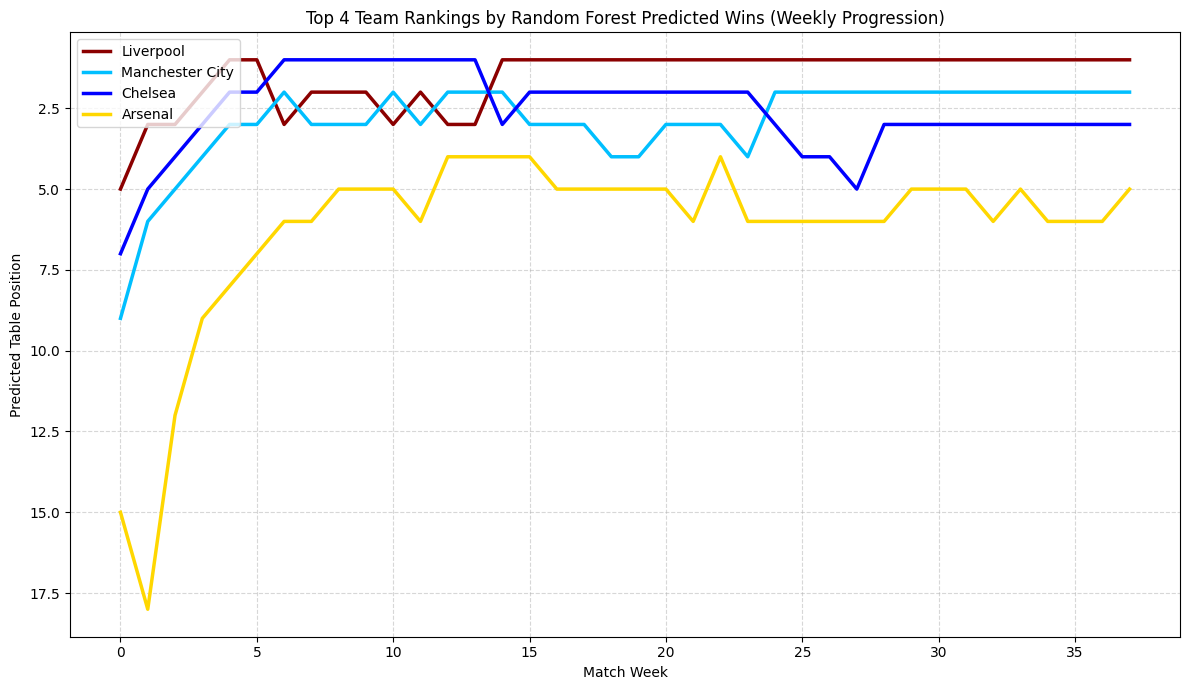

In [22]:
teams = combined_rf['team'].unique()
weeks = sorted(winners_rf_fixed['match_week'].dropna().unique())
full_index = pd.MultiIndex.from_product([teams, weeks], names=['team', 'match_week'])
weekly_wins = winners_rf_fixed.groupby(['team', 'match_week']).size().reindex(full_index, fill_value=0).reset_index(name='rf_win')
weekly_wins['cumulative_rf_wins'] = weekly_wins.groupby('team')['rf_win'].cumsum()
weekly_wins['rank'] = weekly_wins.groupby('match_week')['cumulative_rf_wins'].rank(method='first', ascending=False)

rf_rank_pivot = weekly_wins.pivot(index='match_week', columns='team', values='rank')


deserved_rf_fixed = winners_rf_fixed['team'].value_counts().reset_index()
deserved_rf_fixed.columns = ['team', 'deserved_wins']
top_4_teams = deserved_rf_fixed.head(4)['team'].tolist()


team_colors = {
    'Liverpool': 'darkred',
    'Manchester City': 'deepskyblue',
    'Chelsea': 'blue',
    'Arsenal': 'gold',
    'Tottenham Hotspur': 'gray'
}

plt.figure(figsize=(12, 7))
for team in top_4_teams:
    color = team_colors.get(team, 'black')
    plt.plot(rf_rank_pivot.index, rf_rank_pivot[team], label=team, linewidth=2.5, color=color)

plt.gca().invert_yaxis()
plt.title('Top 4 Team Rankings by Random Forest Predicted Wins (Weekly Progression)')
plt.xlabel('Match Week')
plt.ylabel('Predicted Table Position')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


My next question was to see which of the 2 games Liverpool ended up losing this season? What was the probability of them winning?

In [24]:
combined['match_id'] = combined.groupby(['date_GMT', 'stadium_name']).ngroup()
rf_scores = combined[['match_id', 'team', 'win_prob_rf']]

winners_rf = rf_scores.loc[rf_scores.groupby('match_id')['win_prob_rf'].idxmax()].reset_index(drop=True)
liverpool_wins = winners_rf[winners_rf['team'] == 'Liverpool']['match_id'].unique()
all_liverpool_matches = combined[combined['team'] == 'Liverpool']['match_id'].unique()

liverpool_predicted_losses = set(all_liverpool_matches) - set(liverpool_wins)
non_win_rows = combined[
    (combined['team'] == 'Liverpool') & (combined['match_id'].isin(liverpool_predicted_losses))
][['match_id', 'date_GMT', 'opponent', 'is_home', 'win_prob_rf']]

print(non_win_rows.sort_values('date_GMT'))


     match_id              date_GMT         opponent  is_home  win_prob_rf
589       194  Jan 03 2019 - 8:00pm  Manchester City        0         0.14
447       378  Sep 29 2018 - 4:30pm          Chelsea        0         0.05


It makes sense that the two teams they ended up losing to were both in the top 3; they lost both of the games against the 2 teams under them, and both away from home. Which aligns with exactly what my model predicts. Playing away from home was just too hard for Liverpool!